In [1]:
%matplotlib notebook

In [2]:
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import socket

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [4]:
dataset_root_dir =  "/datasets/ee285f-public/caltech_ucsd_birds/"

In [5]:
class BirdsDataset(td.Dataset):

    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")
    def __len__(self):
        return len(self.data)
    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
                                self.data.iloc[idx]['file_path'])
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
            # COMPLETE
            # torchvision.transforms.Resize(size, interpolation=2)
            tv.transforms.Resize(self.image_size), tv.transforms.ToTensor(), tv.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
        ])
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d

    def number_of_classes(self):
        return self.data['class'].max() + 1


We create a class 'BirdsDataset' that inherits from the class td.Dataset. We define a constructor for the class that sets the image size, mode, as well as the directory path where the images are stored. The constructor also reads data from the root directory.

We define a method __len__ which returns the length of the object that it is called using. The __repr__ method returns a string with information about the mode and the image size of the object used to call it. Another method we define, called the __getitem__, returns the transformed image data of a particular index 'idx'. Depending on the index passed to it, it determines the file path of the image. It then converts the image into RGB and crops it. Then it resizes the image, transforms it into a tensor, and normalises it with 0.5 mean and 0.5 standard deviation for each channel. It returns the transformed image as well as its class.

Another method, called number_of_classes, returns the number of classes associated with an object of class BirdsDataset.

In [6]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

<IPython.core.display.Javascript object>


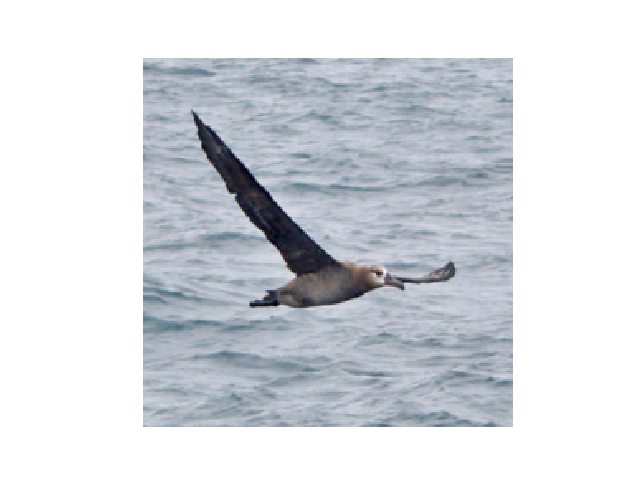

In [7]:
train_set = BirdsDataset(dataset_root_dir, mode="train", image_size=(224, 224))
x = train_set.__getitem__(10)
myimshow(x[0])

In [8]:
train_loader = td.DataLoader(train_set, batch_size = 16, shuffle = True, pin_memory=True)
print(len(train_loader))

47


There are 47 mini batches.

The advantage of using pin memory is that it is allocated using the cudaMallocHost function, which prevents the memory from being swapped out and provides improved transfer speeds. Non-pinned memory is allocated using the malloc function. Pinned memory takes more resources to allocate and deallocate but provides higher transfer throughput for large memory transfers.

<IPython.core.display.Javascript object>


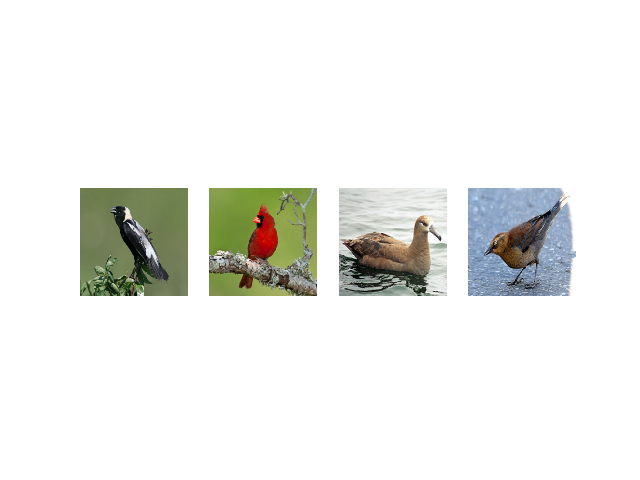

From left to right, image 1 belongs to class  tensor(12)
From left to right, image 2 belongs to class  tensor(16)
From left to right, image 3 belongs to class  tensor(0)
From left to right, image 4 belongs to class  tensor(10)


In [9]:
fig, axes = plt.subplots(ncols=4)
for batch_idx, (data, target) in enumerate(train_loader):
    x = data.__getitem__(1)
    #print(x)
    #myimshow(x)
    myimshow(x, ax=axes[batch_idx])
    print('From left to right, image', batch_idx+1, 'belongs to class ',target[1])
    if(batch_idx==3):
        break
    

Every time the cell is evaluated the images change. This is because we have set shuffle to 'True'. Hence each time dataloader is used to obtain images from the dataset, different images are obtained.

In [10]:
val_set = BirdsDataset(dataset_root_dir, mode="val")
val_loader = td.DataLoader(val_set, batch_size = 16, shuffle = False, pin_memory=True)

We need to shuffle the dataset every time for training. This is to ensure that each minibatch looks different for each epoch. This makes the model less prone to overfitting. We do not do this for the validation set because we use it only for finding the accuracy of our model which is the same no matter what the order of the samples. 

In [11]:
import nntools as nt

In [12]:
net = nt.NeuralNetwork()

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

We get an error because we are trying to instantiate an abstract class. That is we are trying to create an object with methods that are not defined yet. This cannot be permitted and we must define the methods in a subclass so that objects can be created.

In [13]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

In [17]:
vgg = tv.models.vgg16_bn(pretrained=True)

In [18]:
print(vgg) 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

In [19]:
for name, param in vgg.named_parameters():
    print(name, param.size(), param.dtype, param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) torch.float32 True
features.0.bias torch.Size([64]) torch.float32 True
features.1.weight torch.Size([64]) torch.float32 True
features.1.bias torch.Size([64]) torch.float32 True
features.3.weight torch.Size([64, 64, 3, 3]) torch.float32 True
features.3.bias torch.Size([64]) torch.float32 True
features.4.weight torch.Size([64]) torch.float32 True
features.4.bias torch.Size([64]) torch.float32 True
features.7.weight torch.Size([128, 64, 3, 3]) torch.float32 True
features.7.bias torch.Size([128]) torch.float32 True
features.8.weight torch.Size([128]) torch.float32 True
features.8.bias torch.Size([128]) torch.float32 True
features.10.weight torch.Size([128, 128, 3, 3]) torch.float32 True
features.10.bias torch.Size([128]) torch.float32 True
features.11.weight torch.Size([128]) torch.float32 True
features.11.bias torch.Size([128]) torch.float32 True
features.14.weight torch.Size([256, 128, 3, 3]) torch.float32 True
features.14.bias torch.Size([256]

In [20]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
#        self.avgpool = vgg.avgpool
        self.classifier = vgg.classifier

        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)
    def forward(self, x):

        a = self.features(x)
        #f = self.avgpool(a)
        f = torch.flatten(a,1)
        y = self.classifier(f)
        return y

In [21]:
num_classes = train_set.number_of_classes()
netInst = VGG16Transfer(num_classes, fine_tuning=False)
print(netInst)

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fals

In [22]:
for name, param in vgg.named_parameters():
    print(name, param.size(), param.dtype, param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) torch.float32 True
features.0.bias torch.Size([64]) torch.float32 True
features.1.weight torch.Size([64]) torch.float32 True
features.1.bias torch.Size([64]) torch.float32 True
features.3.weight torch.Size([64, 64, 3, 3]) torch.float32 True
features.3.bias torch.Size([64]) torch.float32 True
features.4.weight torch.Size([64]) torch.float32 True
features.4.bias torch.Size([64]) torch.float32 True
features.7.weight torch.Size([128, 64, 3, 3]) torch.float32 True
features.7.bias torch.Size([128]) torch.float32 True
features.8.weight torch.Size([128]) torch.float32 True
features.8.bias torch.Size([128]) torch.float32 True
features.10.weight torch.Size([128, 128, 3, 3]) torch.float32 True
features.10.bias torch.Size([128]) torch.float32 True
features.11.weight torch.Size([128]) torch.float32 True
features.11.bias torch.Size([128]) torch.float32 True
features.14.weight torch.Size([256, 128, 3, 3]) torch.float32 True
features.14.bias torch.Size([256]

In [23]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        accuracy = 100*self.running_accuracy / self.number_update
        return {'loss': loss, 'accuracy': accuracy}

The method 'eval' sets the module in evaluation mode. Some modules differ in their behaviour during training mode and evaluation mode. For example a module that uses dropout does must behave differently while training and evaluation. In such cases, when we set the module in evaluation mode, we only use the procedures that are valid for the evaluation mode.

In [24]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
                     output_dir="birdclass1", perform_validation_during_training=True)

In the directory birdclass1, there exist two files, 'checkpoint.pth.tar' and 'config.txt'. The former is a binary file containing the state of the experiment. The latter is an ASCII file describing the setting of the experiment. After each epoch, a checkpoint file will be created in the directory. While restarting the experiment, the settings and state from the output_dir will be loaded, and the experiment will be continued from where it had stopped.

When the learning rate is changed from 0.001 to 0.0001, we observe that the system throws an error because it cannot create the experiment as there is a checkpoint conflicting with the current setting. If we change the name of the directory to be different for the new learning rate, the system does not throw an error, thus implying that the created directory is specific to the experiment.

In [25]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
                 label="training loss")
    # COMPLETE
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
                 label="evaluation loss")
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
                 label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
                 label="evaluation accuracy")
    plt.tight_layout()
    fig.canvas.draw()

<IPython.core.display.Javascript object>


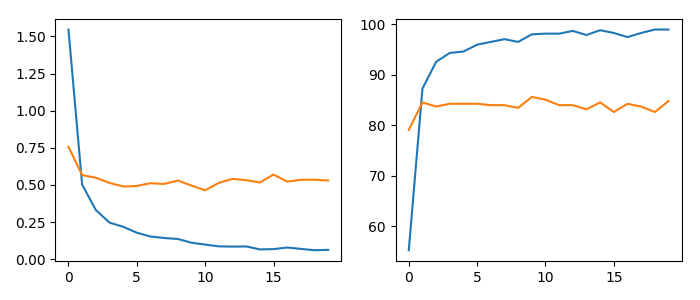

Start/Continue training from epoch 20
Finish training for 20 epochs


In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [27]:
resnet = tv.models.resnet18(pretrained=True)

In [28]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [29]:
class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        vgg = tv.models.resnet18(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = fine_tuning
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4
        self.avgpool = resnet.avgpool
        self.fc = resnet.fc
        # COMPLETE
        num_ftrs = resnet.fc.in_features
        self.fc = nn.Linear(num_ftrs, num_classes)
    def forward(self, x):
        # COMPLETE
        a = self.conv1(x)
        a = self.bn1(a)
        a = self.relu(a)
        a = self.maxpool(a)
        a = self.layer1(a)
        a = self.layer2(a)
        a = self.layer3(a)
        a = self.layer4(a)
        f = self.avgpool(a)
        f = torch.flatten(f,1)
        y = self.fc(f)
        return y

In [30]:
lr = 1e-3
net = Resnet18Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
                     output_dir="birdclass2", perform_validation_during_training=True)

<IPython.core.display.Javascript object>


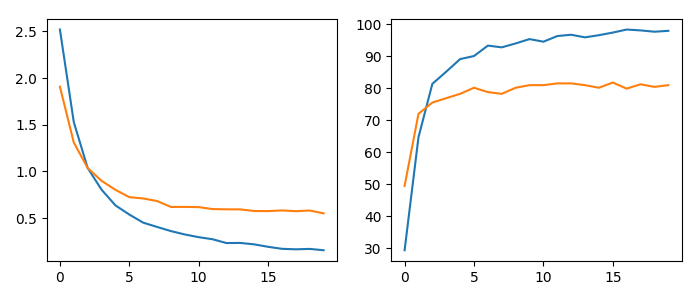

Start/Continue training from epoch 20
Finish training for 20 epochs


In [31]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

In [32]:
print('The loss and accuracy for VGG are',exp1.evaluate())
print('The loss and accuracy for Resnet are: ', exp2.evaluate())

The loss and accuracy for VGG are {'loss': 0.5302223009259804, 'accuracy': tensor(84.7826, device='cuda:0')}
The loss and accuracy for Resnet are:  {'loss': 0.550921296943789, 'accuracy': tensor(80.9783, device='cuda:0')}


For the given dataset, a VGG is more accurate at 84.7826% than a ResNet at 80.7826%.